In [1]:
# Set up a cluster using dask
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()

cluster.scale(20)
cluster

In [2]:
#Make a client so you can see the progress of tasks (click the link that appears below)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.5bcab627e399438db0a415c4dc03b953/status,


In [3]:
import intake
import pandas as pd
import pprint
import fsspec

import numpy as np
import xarray as xr
import xgcm
import s3fs
import xesmf as xe

import matplotlib.pyplot as plt
%matplotlib inline

from fastjmd95 import jmd95numba

In [4]:
col = intake.open_esm_datastore(
    "https://raw.githubusercontent.com/NCAR/cesm-lens-aws/main/intake-catalogs/aws-cesm1-le.json")
col_subset = col.search(experiment="20C",variable=["TEMP", "SALT","PD","UVEL","VVEL","WVEL","SHF","VNT","WTT"])
#col_subset = col.search(experiment="20C",variable=["TEMP"])
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/tmp/ipykernel_510/1335283246.py:5: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})


In [5]:
ds = dsets['ocn.20C.monthly']
theta = ds.TEMP
salt = ds.SALT
uvel = ds.UVEL
vvel = ds.VVEL
wvel = ds.WVEL
vnt = ds.VNT
wtt = ds.WTT
pot_dens = ds.PD

shf = ds.SHF

url = "s3://ncar-cesm-lens/ocn/static/grid.zarr"
fs = s3fs.S3FileSystem(anon=True)
grid_ds = xr.open_zarr(s3fs.S3Map(url, s3=fs))

In [6]:
th0 = theta.roll(nlon=60).sel(nlon=slice(0,130))
slt0 = salt.roll(nlon=60).sel(nlon=slice(0,130))
uvel0 = uvel.roll(nlon=60).sel(nlon=slice(0,130))
vel0 = vvel.roll(nlon=60).sel(nlon=slice(0,130))
wvel0 = wvel.roll(nlon=60).sel(nlon=slice(0,130))
pd0 = pot_dens.roll(nlon=60).sel(nlon=slice(0,130))
#vnt0 = vnt.roll(nlon=60)
#wtt0 = wtt.roll(nlon=60)
shf0 = shf.roll(nlon=60).sel(nlon=slice(0,130))
grid0 = grid_ds.roll(nlon=60,roll_coords=True).sel(nlon=slice(0,130))

#uvel0=uvel0.rename({'nlon':'vlon','nlat':'vlat'})
#vel0=vel0.rename({'nlon':'vlon','nlat':'vlat'})

In [7]:
#create grid object

#first merge v and w 
vel = vel0.to_dataset().merge(wvel0)
z_outer = np.concatenate((vel.z_w_top.values,np.asarray(500000).reshape((-1,))))
vel = vel.assign_coords(z_w_outer=z_outer)

from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

grid = Grid(vel, coords={'Z': {'center': 'z_t','outer': 'z_w_outer'}},periodic=False)

#calculate dz
dz = grid.diff(vel.z_w_outer,axis='Z',boundary='extend')

In [8]:
#Create a region mask for the Atlantic
atl_mask = grid0.REGION_MASK
atl_mask = atl_mask.where((atl_mask==6) | (atl_mask==8)| (atl_mask==-12))
atl_mask = atl_mask.where(np.isnan(atl_mask),1)

In [9]:
pd_jmd = jmd95numba.rho(slt0, th0, 0)
pd_jmd1 = jmd95numba.rho(slt0, th0, 1000)

rho_axis=np.concatenate((np.arange(20,27,0.1),np.arange(27,28.1,0.01)))


#transform into density coords
MOC = grid.transform(vel.VVEL*grid0.DXT*dz*atl_mask/100**3, target = rho_axis, target_data=(pd0*1000-1000), 
                     method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

thickness = grid.transform(xr.ones_like(vel.VVEL)*dz*atl_mask/100, target = rho_axis, target_data=(pd0*1000-1000), 
                     method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:1109: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:303: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.<function raw_interp_function at 0x7a67ce5a4280>` instead of `Axis.<function raw_interp_function at 0x7a67ce5a4280>`
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/t

In [10]:
def stretch(rho):
    stretched = rho-22
    stretched[(rho>26.5) & (rho<27.8)] = (stretched[(rho>26.5) & (rho<27.8)]-4.5)*5+4.5
    stretched[(rho>=27.8)] = (stretched[(rho>=27.8)]-5.8)*10+11
    return stretched

In [11]:
#find the depths of some isopycnals
timeslice = slice('1940-01-01','2016-02-01')
thickness_mask = xr.ones_like(thickness).where(thickness>0)
tn_mean = (((thickness.cumsum('PD')*thickness_mask).sel(member_id=1,time=slice('2000-01-01','2016-01-01')).sum('time',skipna=False)).sum('nlon')
          )/((thickness_mask.sel(member_id=1,time=slice('2000-01-01','2016-01-01'))*atl_mask).sum('time',skipna=False).sum('nlon'))

MOC_mean = (MOC.sel(member_id=1,time=timeslice).mean('time').sum('nlon').cumsum('PD')/10**6)
MOC_mean.coords['depth']=(-tn_mean.ffill('PD').bfill('PD'))
MOC_mean.coords['latitude'] = grid0.TLAT.mean('nlon')

In [12]:
#MOC_loded = (MOC.sel(member_id=1,time=slice('1980-01-01','2016-01-01')).mean('time').sum('nlon').cumsum('PD')/10**6).load()

In [14]:
#create grid object

uvel0=uvel0.rename({'nlon':'vlon','nlat':'vlat'})
vel0=vel0.rename({'nlon':'vlon','nlat':'vlat'})
#first merge v and w 

ds = vel0.to_dataset().merge(wvel0)
ds = ds.merge(th0)
ds = ds.merge(uvel0)
ds = ds.merge(pd0)
ds = ds.merge(grid0.DXU.rename({'nlon':'vlon','nlat':'vlat'}).rename('gridS'))
ds = ds.merge(grid0.DYU.rename({'nlon':'vlon','nlat':'vlat'}).rename('gridW'))
z_outer = np.concatenate((ds.z_w_top.values,np.asarray(550000).reshape((-1,))))
ds = ds.assign_coords(z_w_outer=z_outer)

from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

grid = Grid(ds, coords={'X':{'center': 'nlon','right': 'vlon'},'Y':{'center': 'nlat','right': 'vlat'},'Z': {'center': 'z_t','outer': 'z_w_outer'}},periodic=False)

#calculate dz
dz = grid0.dz#grid.diff(ds.z_w_outer,axis='Z',boundary='extend')

In [15]:
latit = slice(120,370)
#Create a region mask for the Atlantic
atl_mask = grid0.REGION_MASK
atl_mask = atl_mask.where((atl_mask==6) | (atl_mask==8) | (atl_mask==9)| (atl_mask==11))
atl_mask = atl_mask.where(np.isnan(atl_mask),1)
atl_mask = atl_mask.where((atl_mask.nlon<108) | (atl_mask.nlat>331))
maskS = atl_mask.rename({'nlat':'vlat'}).sel(vlat=latit)

In [16]:
pick_id = 1

vs = grid.interp(ds.VVEL*ds.gridS,'X',boundary='fill').sel(vlat=latit).sel(member_id=pick_id)
deltaxS = grid.interp(ds.gridS,'X',boundary='fill').sel(vlat=latit)
pdS = grid.interp(ds.PD*1000,'Y',boundary='fill').sel(vlat=latit).sel(member_id=pick_id)

vel_mean = (vs*dz*maskS).sum(['nlon','z_t'])/(xr.ones_like(vs).where(np.isfinite(vs))*dz*maskS).sum(['nlon','z_t'])

vel_notf = vs - vel_mean

pd_jmd = jmd95numba.rho(slt0, th0, 0)
pd_jmd1 = jmd95numba.rho(slt0, th0, 1000)

#rho_axis=np.concatenate((np.arange(20,27,0.1),np.arange(27,28.1,0.01)))
rho_axis1=np.concatenate((np.arange(20,27.6,0.1),np.arange(27.7,28.1,0.01)))
#rho_axis1=np.arange(25,33,0.1)

#transform into density coords
MOC_jmd1 = grid.transform(vel_notf*dz*maskS/100**3, target = rho_axis1, target_data=(pdS.rename('PD')-1000), 
                     method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

#transport in member 1
transport_1 = MOC_jmd1

transport_43N = transport_1.sel(time=timeslice)#.rolling(time=3).mean().dropna("time",how='all')


PDloc=80
transport_above = transport_43N.isel(PD=slice(0,PDloc)).sum('PD')

/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:1109: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:303: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.<function raw_interp_function at 0x7a67ce5a4280>` instead of `Axis.<function raw_interp_function at 0x7a67ce5a4280>`
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/t

In [17]:

lons_40 = atl_mask.TLONG[286,23:90].values
lons_40[lons_40>180] = lons_40[lons_40>180]-360
lats_40 = atl_mask.TLAT[286,23:90].values


lons_26 = atl_mask.TLONG[270,23:85].values
lons_26[lons_26>180] = lons_26[lons_26>180]-360
lats_26 = atl_mask.TLAT[270,23:85].values

lons_m5 = atl_mask.TLONG[163,60:125].values
lons_m5[lons_m5>180] = lons_m5[lons_m5>180]-360
lats_m5 = atl_mask.TLAT[163,60:125].values

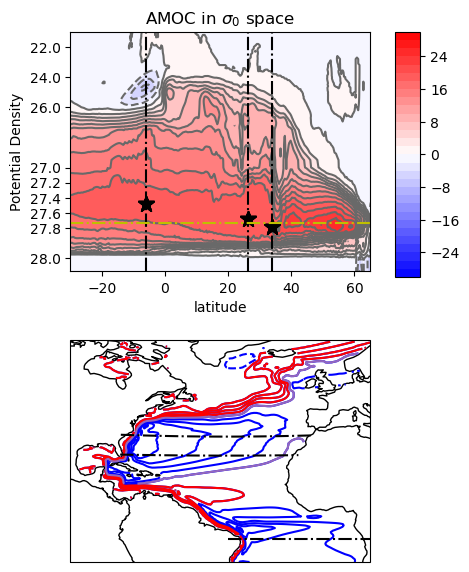

In [18]:
import cartopy.crs as ccrs
import cartopy

fig = plt.figure(figsize=(5,7))
gs = fig.add_gridspec(2, 1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])

cs = plt.contourf(grid0.TLAT.mean('nlon').values,stretch(rho_axis[0:-1]),
             (MOC.sel(member_id=1,time=slice('1980-01-01','2016-01-01')).mean('time').sum('nlon').cumsum('PD')/10**6).squeeze().values.T, 
                  levels=np.arange(-30,31,2),cmap='bwr')
plt.contour(grid0.TLAT.mean('nlon').values,stretch(rho_axis[0:-1]),
             (MOC.sel(member_id=1,time=slice('1980-01-01','2016-01-01')).mean('time').sum('nlon').cumsum('PD')/10**6).squeeze().values.T, 
                  levels=np.arange(-30,31,2),colors='dimgrey')
plt.yticks(stretch(np.concatenate((np.arange(21,27,2),np.arange(27,28.4,0.2)))),labels=np.round(np.concatenate((np.arange(22,27,2),np.arange(27,28.4,0.2))),1))

plt.ylabel('Potential Density')
plt.xlabel('latitude')

plt.title('AMOC in $\sigma_0$ space')


hloc = stretch(np.asarray([27.785, 27.785]))
plt.plot([34, 34],[hloc,hloc],marker='*',markersize=12,color='k')
plt.axvline(34,color='k',lw=1.5,ls='-.')

hloc = stretch(np.asarray([27.68, 27.68]))
plt.plot([26.2, 26.2],[hloc,hloc],marker='*',markersize=12,color='k')
plt.axvline(26.2,color='k',lw=1.5,ls='-.')


hloc = stretch(np.asarray([27.49, 27.49]))
plt.plot([-6, -6],[hloc,hloc],marker='*',markersize=12,color='k')
plt.axvline(-6,color='k',lw=1.5,ls='-.')

hloc = stretch(np.asarray([27.74, 27.74]))
plt.axhline(hloc[0],color='y',lw=1.5,ls='-.')

plt.xlim(-30,65)
plt.gca().invert_yaxis()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.53, 0.05, 0.35])
fig.colorbar(cs, cax=cbar_ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())

ds_out = xr.Dataset({'lat': (['lat'], np.arange(-15, 70, 0.5)),
                     'lon': (['lon'], np.arange(-100, 15, 0.1)),
                    }
                   )

transport_sf = ((transport_above.mean('time')).cumsum('nlon')*maskS).rename({'TLONG':'lon','TLAT':'lat'}).drop_vars(['ULONG','ULAT']).load()
regridder = xe.Regridder(transport_sf, ds_out, 'bilinear')
dr_out = regridder(transport_sf)



ax.coastlines()

cs=ax.contour(dr_out.lon,dr_out.lat,dr_out.values/10**6,levels=np.arange(-30,50,5),colors='b',
                          transform = ccrs.PlateCarree())

ax.contour(dr_out.lon,dr_out.lat,dr_out.values/10**6,levels=np.arange(0,20,5),colors='r',
                          transform = ccrs.PlateCarree())

ax.contour(dr_out.lon,dr_out.isel(lat=slice(60,180)).lat,dr_out.isel(lat=slice(60,180)).values/10**6,levels=[-20,20],colors='tab:purple',
                          transform = ccrs.PlateCarree())

ax.plot(lons_26,lats_26,'k',transform = ccrs.PlateCarree(),linestyle='-.')
ax.plot(lons_m5,lats_m5,'k',transform = ccrs.PlateCarree(),linestyle='-.')
                                  
ax.plot(lons_40,lats_40,'k',transform = ccrs.PlateCarree(),linestyle='-.')   

ax.set_extent([-100, 15, -15, 70], crs=ccrs.PlateCarree())

plt.subplots_adjust(hspace=0.25,left=0.2)

fig = plt.gcf()
#fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1,wspace=0.1)
fig.savefig('MOC_pseudo.png')

In [19]:
cluster.shutdown()